In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [ ]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


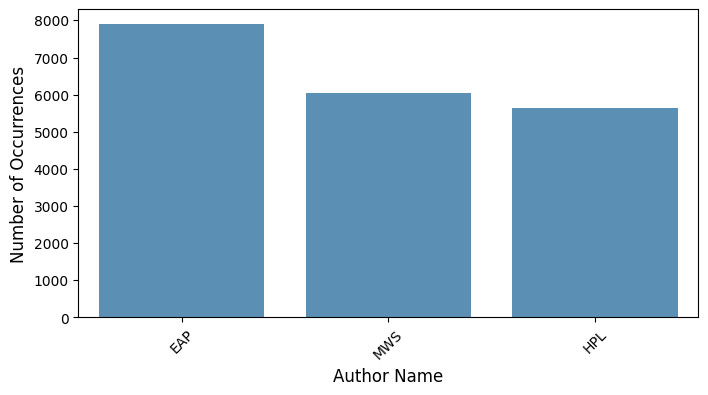

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

In [ ]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

In [ ]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

<ipython-input-12-bf56f77c0a98>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals


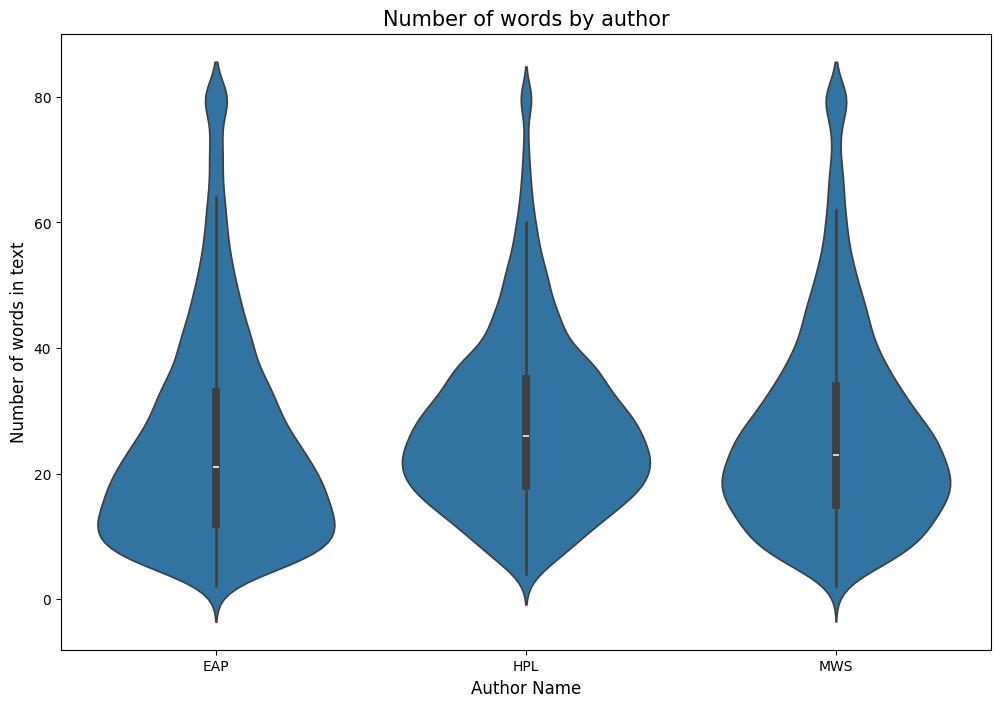

In [ ]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

<ipython-input-13-1fa9d0c7c289>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals


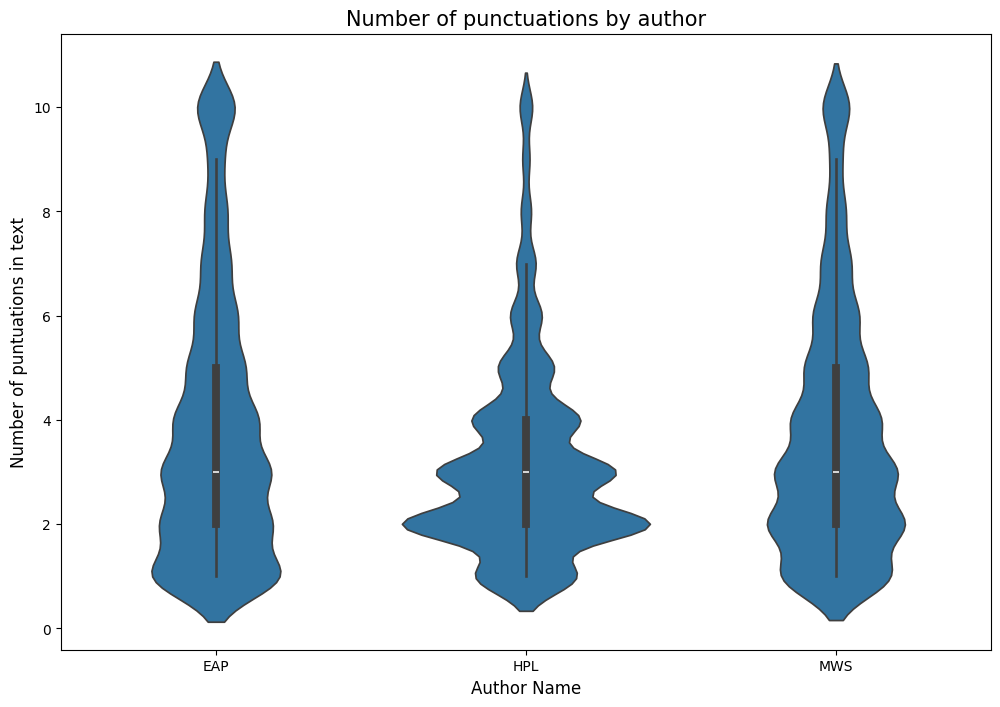

In [ ]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

In [ ]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [ ]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [ ]:
from sklearn import model_selection
from sklearn.metrics import log_loss
import numpy as np
import xgboost as xgb

def runXGB(train_X, train_y, val_X, val_y, test_X, seed_val=0, num_rounds=500, early_stopping_rounds=50):
    # Prepare the data
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    xgval = xgb.DMatrix(val_X, label=val_y)
    xgtest = xgb.DMatrix(test_X)

    # Parameters
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,  # Adjust based on your specific use case
        'eval_metric': 'mlogloss',
        'seed': seed_val,
    }

    # Train the model with validation set
    evals = [(xgtrain, 'train'), (xgval, 'val')]
    model = xgb.train(params, xgtrain, num_rounds, evals=evals, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    # Predictions
    pred_val_y = model.predict(xgval)
    pred_test_y = model.predict(xgtest)

    return pred_val_y, pred_test_y, model

# K-Fold cross-validation
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test += pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(log_loss(val_y, pred_val_y))

print("cv scores:", cv_scores)

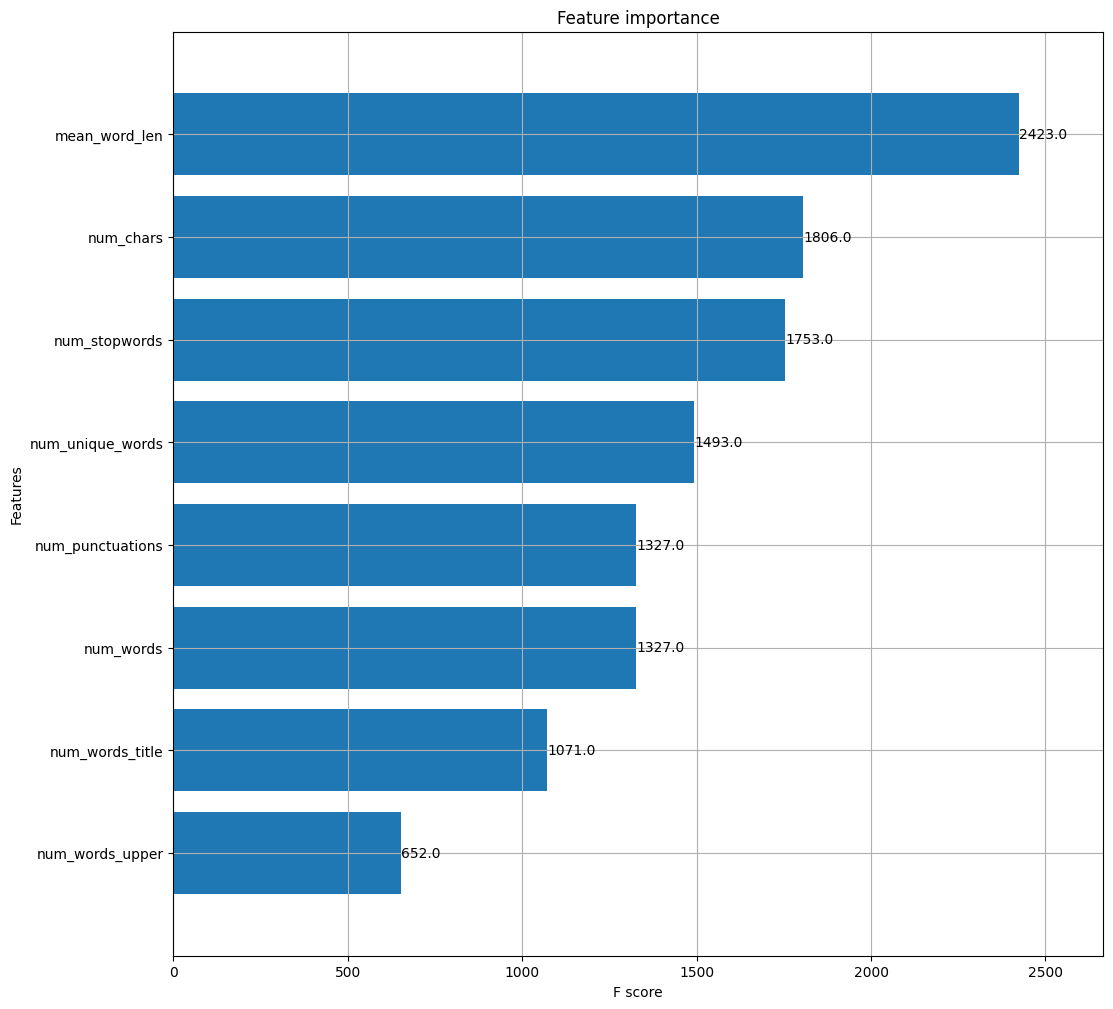

In [ ]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [ ]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [ ]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.8422161983612853


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

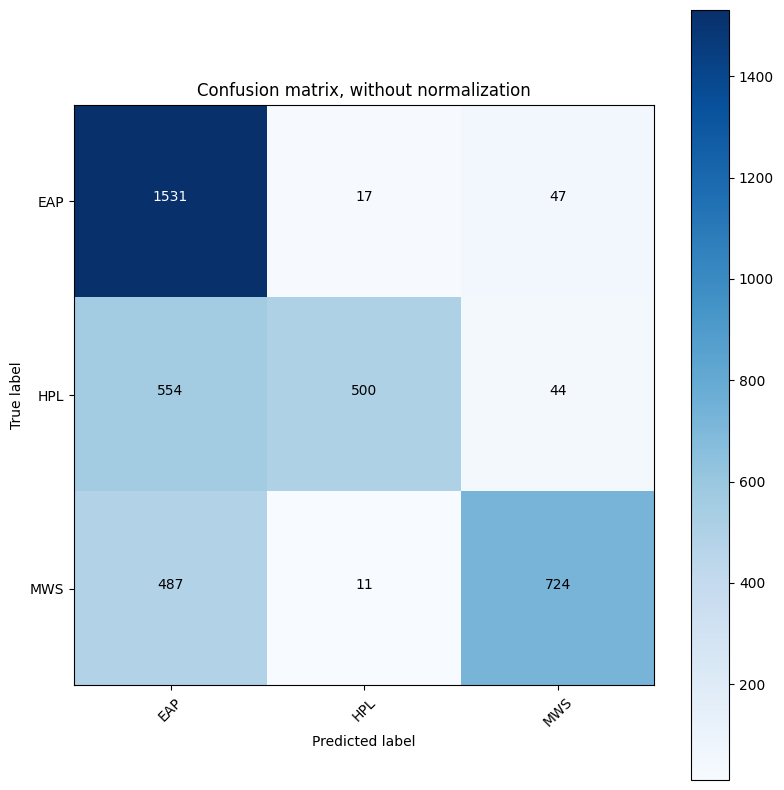

In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [ ]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.45091841616567424


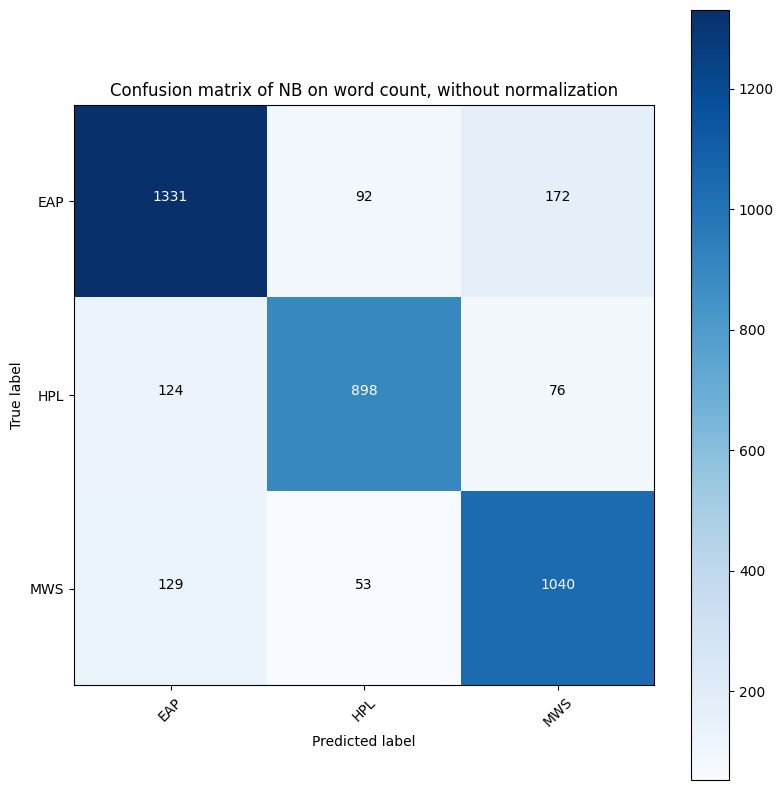

In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

In [ ]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947422


In [ ]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
# Define the runXGB function without colsample parameter
def runXGB(train_X, train_y, val_X, val_y, test_X, seed_val=0, num_rounds=500, early_stopping_rounds=50):
    # Prepare the data
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    xgval = xgb.DMatrix(val_X, label=val_y)
    xgtest = xgb.DMatrix(test_X)

    # Parameters
    params = {
        'objective': 'multi:softprob',
        'num_class': 3,  # Adjust based on your specific use case
        'eval_metric': 'mlogloss',
        'seed': seed_val,
        'colsample_bytree': 0.7  # Set colsample_bytree here if needed
    }

    # Train the model with validation set
    evals = [(xgtrain, 'train'), (xgval, 'val')]
    model = xgb.train(params, xgtrain, num_rounds, evals=evals, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

    # Predictions
    pred_val_y = model.predict(xgval)
    pred_test_y = model.predict(xgtest)

    return pred_val_y, pred_test_y, model

# Prepare data
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop + ['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

# K-Fold cross-validation
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test += pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(log_loss(val_y, pred_val_y))

print("cv scores:", cv_scores)

# Prepare output DataFrame
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[0]	train-mlogloss:0.81560	val-mlogloss:0.82532
[1]	train-mlogloss:0.64576	val-mlogloss:0.66288
[2]	train-mlogloss:0.53628	val-mlogloss:0.56312
[3]	train-mlogloss:0.45971	val-mlogloss:0.49445
[4]	train-mlogloss:0.40511	val-mlogloss:0.44644
[5]	train-mlogloss:0.36653	val-mlogloss:0.41499
[6]	train-mlogloss:0.33594	val-mlogloss:0.39157
[7]	train-mlogloss:0.31272	val-mlogloss:0.37637
[8]	train-mlogloss:0.29394	val-mlogloss:0.36459
[9]	train-mlogloss:0.27817	val-mlogloss:0.35418
[10]	train-mlogloss:0.26471	val-mlogloss:0.34668
[11]	train-mlogloss:0.25411	val-mlogloss:0.34109
[12]	train-mlogloss:0.24506	val-mlogloss:0.33581
[13]	train-mlogloss:0.23779	val-mlogloss:0.33205
[14]	train-mlogloss:0.23074	val-mlogloss:0.32972
[15]	train-mlogloss:0.22406	val-mlogloss:0.32651
[16]	train-mlogloss:0.21756	val-mlogloss:0.32372
[17]	train-mlogloss:0.21206	val-mlogloss:0.32267
[18]	train-mlogloss:0.20477	val-mlogloss:0.32054
[19]	train-mlogloss:0.19886	val-mlogloss:0.31945
[20]	train-mlogloss:0.19444	va

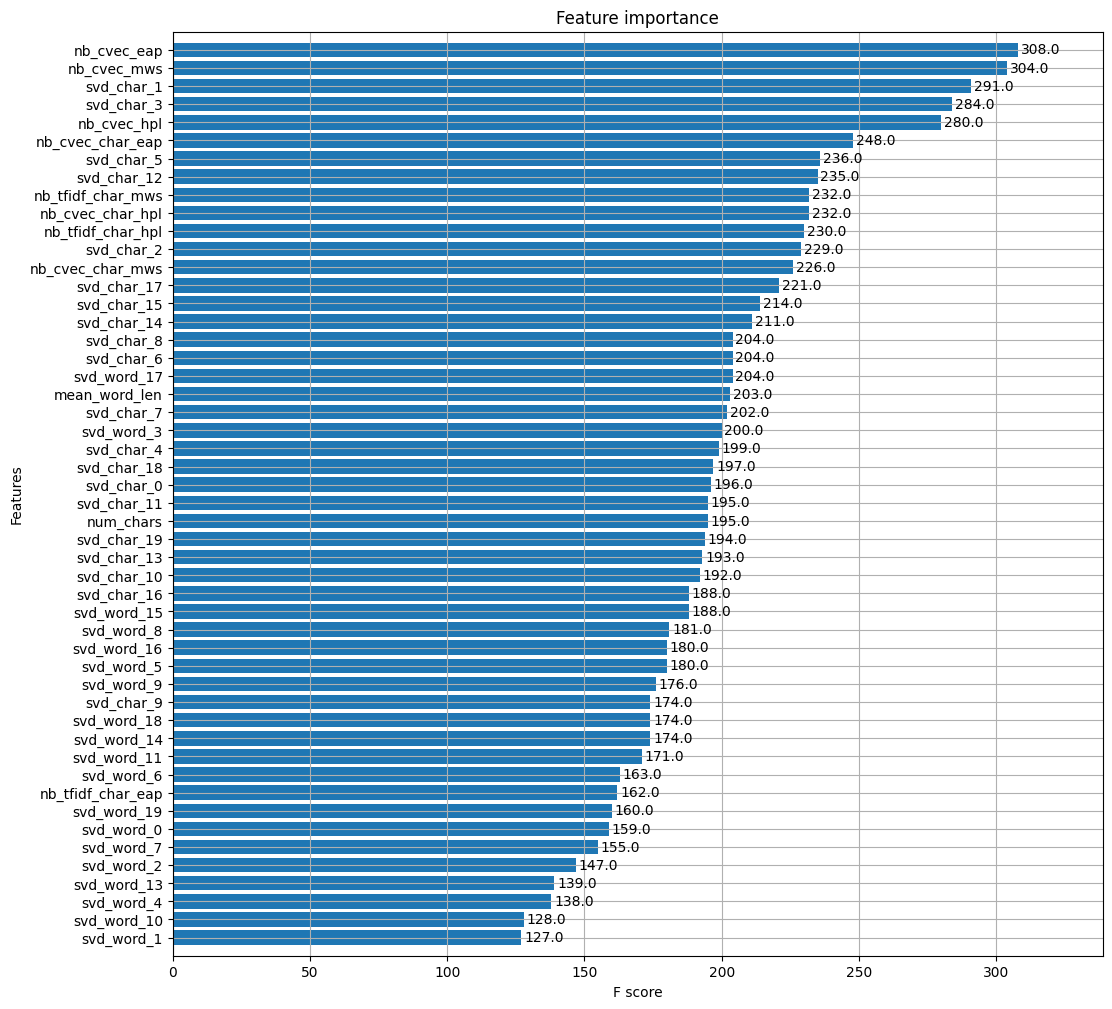

In [ ]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

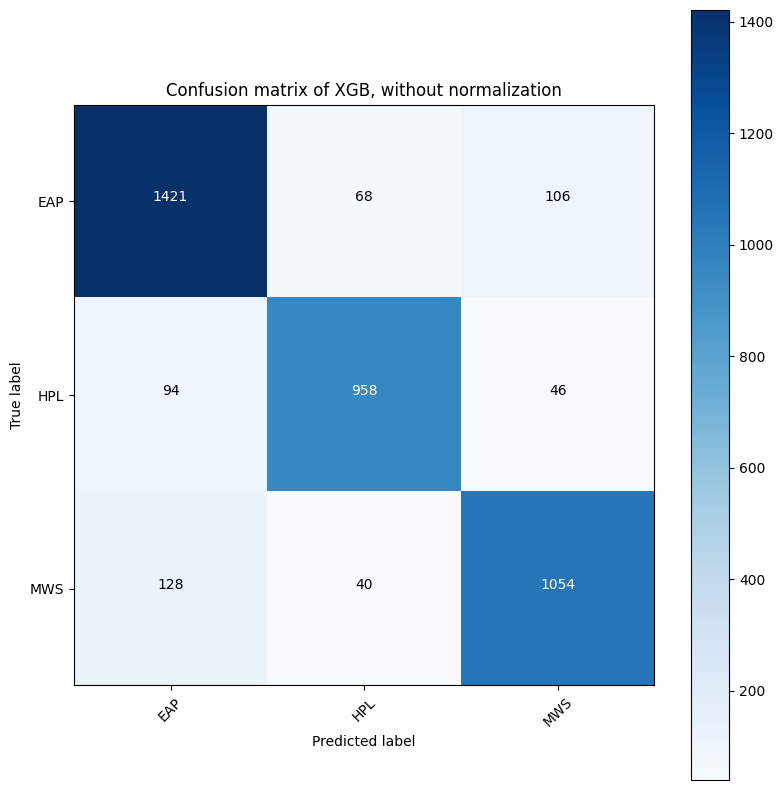

In [ ]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of XGB, without normalization')
plt.show()